In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Create a 3D dataset

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

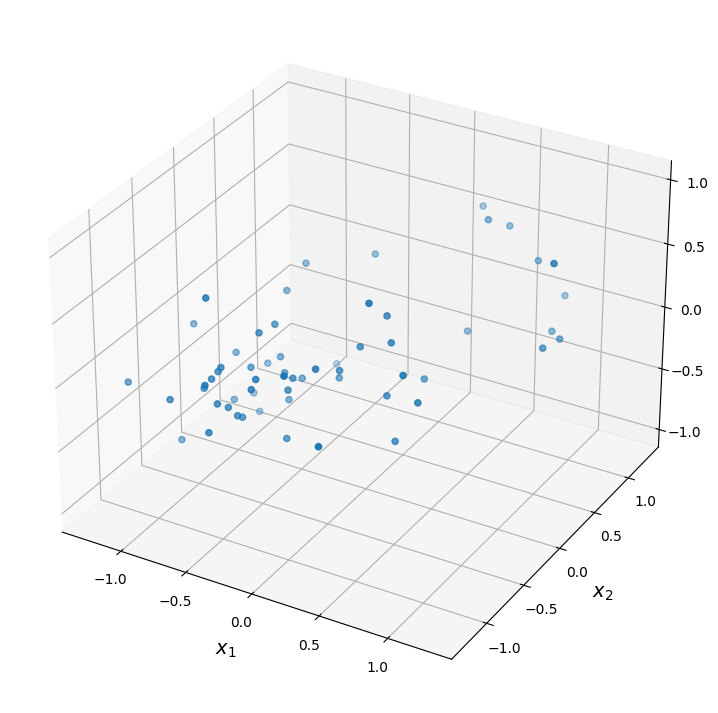

In [3]:
import matplotlib.pyplot as plt

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:, 0], X[:, 1], X[:, 2])

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

# Scikit-learn PCA

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [5]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

# Explained Variance Ratio
Another very useful information is the **explained variance ratio** of each principal component, which can be obtained through the *explained_variance_ratio_* variable. It represents the proportion of the variance of the data set that lies on each principal component axis.

In [6]:
# let's look at the variance explained for the first two components of the three-dimensional data set
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

The first dimension explains about 76% of the variance, while the second explains about 15%.


By projecting down to 2D, we lost about 9% of the variance:

In [7]:
1 - pca.explained_variance_ratio_.sum()

0.09028309326742034

# Choosing the Right Number of Dimensions
- Usually we tend to choose the number of dimensions that add up to a sufficient proportion of variance explanation (e.g. 95%), rather than arbitrarily choosing the number of dimensions to reduce to.
- Unless you are reducing the dimensionality for data visualization -- in which case you usually want to reduce the dimensionality to 2 or 3.

In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

# manually decide d
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) # calculate the cumulative sum of the elements along a given axis.

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
cumsum >= 0.95

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [11]:
d = np.argmax(cumsum >= 0.95) + 1
d

154

There is a better option: instead of specifying the number of principal components you want to retain, set n_components to a floating point number between 0.0 and 1.0 indicating the ratio of variance you wish to retain

In [12]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [13]:
pca.n_components_

154

In [14]:
pca.explained_variance_ratio_.sum()

0.9501960192613035

- Another option is to plot the variance explained as a function of dimensionality.
- There is usually an elbow in the curve where the variance explained stops growing rapidly. You can think of this as the true dimensionality of your data set.
- In this case, you can see that reducing the dimensionality to about 65 dimensions does not lose much explained variance.

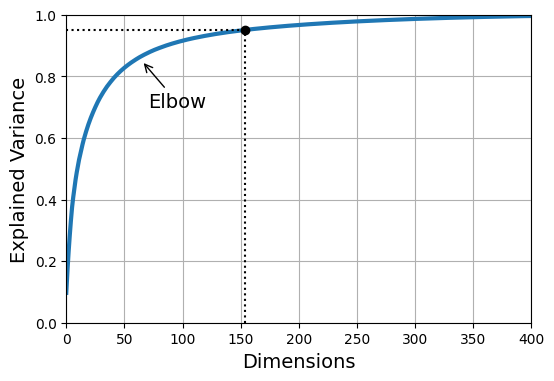

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

Of course you can also use **GridSearch** to find the optimal number of dimensions.

# PCA Decompression

In [16]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train)

In [17]:
X_recovered = pca.inverse_transform(X_reduced)

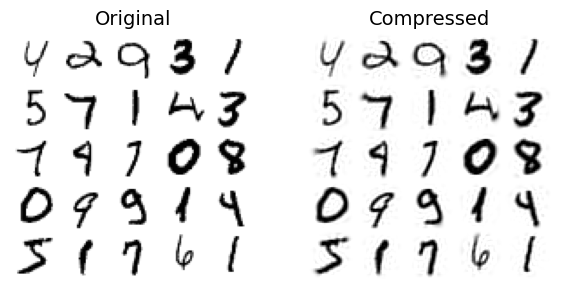

In [18]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")


# Other Dimensionality Reduction Approach
- Locally Linear Embedding (LLE)
- Multidimensional Scaling (MDS)
- Isomap
- t-Distributed Stochastic Neighbor Embedding (t-SNE)


In [19]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

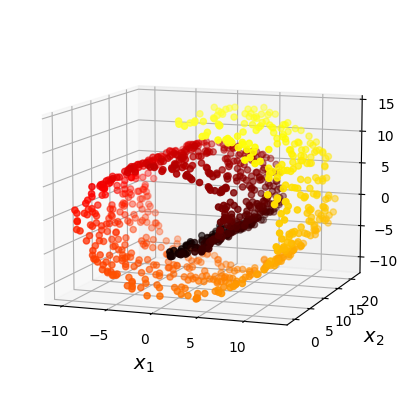

In [25]:
from matplotlib.colors import ListedColormap

axes = [-11.5, 14, -2, 23, -12, 15]

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
plt.show()

In [26]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_swiss)

In [27]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [28]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

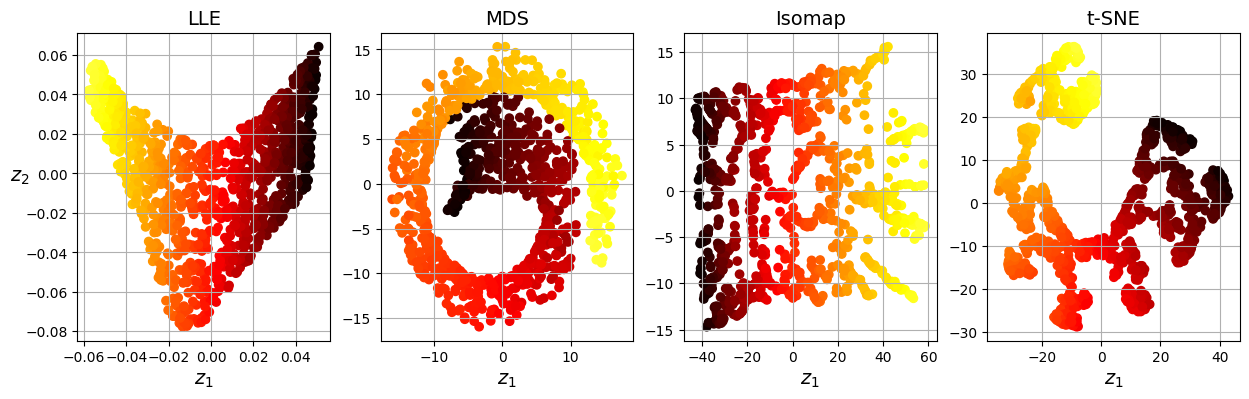

In [30]:
titles = ["LLE", "MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(15, 4))

for subplot, title, X_reduced in zip((141, 142, 143, 144), titles,
                                     (X_reduced_lle, X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 141:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()

# Assignment (3%)
Exercise 1: _Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing)._

Exercise 2: _Train a Random Forest classifier (estimator number=100, random state=42) on the dataset and time how long it takes, then evaluate the resulting model on the test set (use 'accuracy_score')._

To time how long a code runs, use '%time'.

Ex: %time print('hello world')

Exercise 3: _Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%._

Exercise 4: _Train a new Random Forest classifier (estimator number=100, random state=42) on the reduced dataset and see how long it takes. Was training much faster? (The results may surprise you)_

Exercise 5: _Next evaluate the classifier on the test set: how does it compare to the previous classifier? (make sure to transform the test data using 'pca.transform()')_

Exercise 6: _Try again with an `SGDClassifier` (random state=42). Print the training time and accuracy of SGD with and without PCA, respectively_